In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tqdm.notebook import tqdm

from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')

## Load data

In [3]:
train = pd.read_csv("data/HeadHunter_train.csv")
test = pd.read_csv("data/HeadHunter_test.csv")
sample_submission = pd.read_csv("data/HeadHunter_sample_submit.csv")

print(f"Train shape: {train.shape} | Test shape: {test.shape}")

Train shape: (50876, 12) | Test shape: (50651, 11)


## EDA

In [4]:
train.head()

,review_id,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target
0,0,Ижевск,Кладовщик,Недавно устроился в ****** на должность кладов...,Повысить з/п,5,4,3,3,4,4,0
1,1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (...",Упростить процессы - все процессы ради процесс...,4,4,4,1,1,1,8
2,2,Екатеринбург,Консультант,В нашем банке все по закону в плане зарплаты и...,Ничего,5,5,5,5,5,5,0
3,5,Санкт-Петербург,Оператор,Я в ****** около года работаю оператором. Норм...,Нет.,5,5,5,5,5,5,0
4,7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,4,5,4,2,5,2,8


In [5]:
test.head()

,review_id,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating
0,3,Москва,Старший специалист,"Свобода в выборе рабочего графика, условия труда",****** всегда стремится к улучшению всего,5,5,5,5,5,5
1,4,Москва,Менеджер по персоналу,Компания делает ставки на молодых и перспективных,"Слабая оснащённость рабочих мест, отсутствие Д...",4,5,4,5,4,4
2,13,Тверь,Тренинг-менеджер,Есть возможность для развития,Увеличить уровень дохода,2,5,5,5,5,5
3,14,Уфа,Специалист отдела кадров,"Хороший коллектив, размереная работа, нет пере...","Обучение сотрудников, ротацию кадров, увеличе...",2,5,5,2,4,4
4,17,Москва,Бизнес-аналитик,"Гибкость в рабочем графике, коллектив.",Уровень представленности HR-бренда.,5,5,5,5,5,5


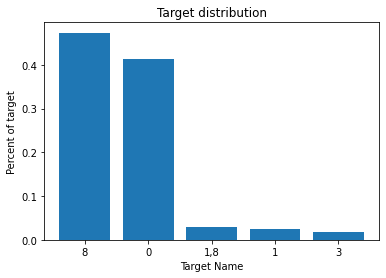

In [6]:
plt.bar([i[0] for i in train[["target"]].value_counts(normalize=True).iloc[:5].index.values],
        train[["target"]].value_counts(normalize=True).iloc[:5].values)
plt.ylabel("Percent of target")
plt.xlabel("Target Name")
plt.title("Target distribution")
plt.show()

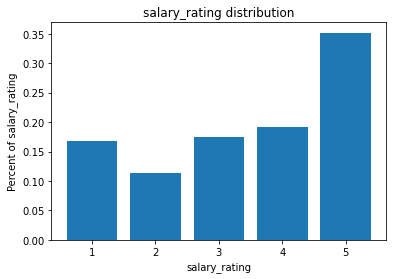

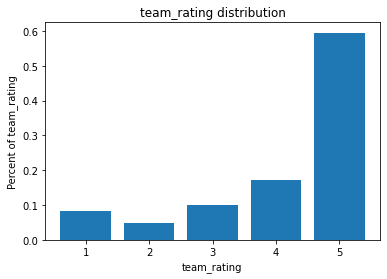

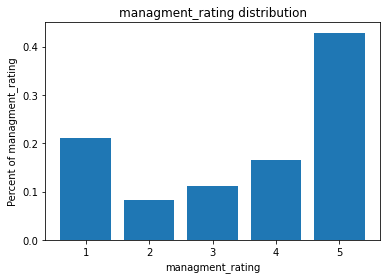

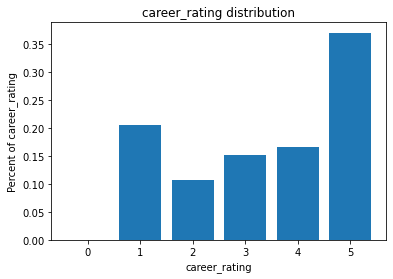

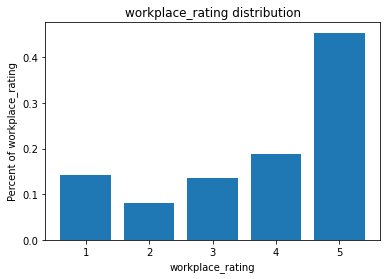

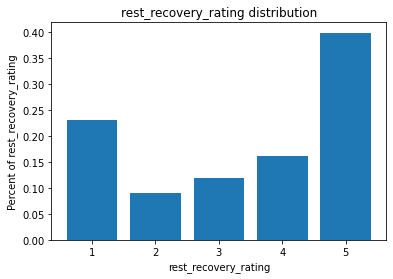

In [7]:
# metadata distribution
metadata_columns = ["salary_rating", "team_rating", "managment_rating", "career_rating",
                    "workplace_rating", "rest_recovery_rating"]
for feature in metadata_columns:
    plt.bar([i[0] for i in train[[feature]].value_counts(normalize=True).index.values],
            train[[feature]].value_counts(normalize=True).values)
    plt.ylabel(f"Percent of {feature}")
    plt.xlabel(f"{feature}")
    plt.title(f"{feature} distribution")
    plt.show()

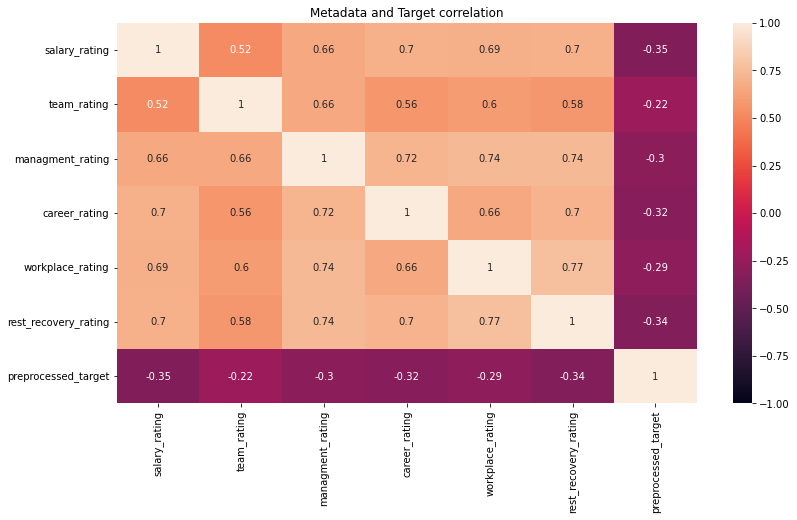

In [8]:
# correlation plot
train["preprocessed_target"] = train["target"].str.split(",").apply(lambda x: x[0]).astype(int)
corr = train[metadata_columns + ["preprocessed_target"]].corr()

plt.figure(figsize=(13, 7))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title("Metadata and Target correlation")
plt.show()

In [9]:
# metadata by target
train["metadata_sum"] = train[metadata_columns].sum(axis=1)
train.groupby(["target"])["metadata_sum"].agg(["mean", "median", "max", "min", "count"]).sort_values("mean", ascending=False).head(7)

,mean,median,max,min,count
target,,,,,
"3,6",29.000000,29.0,29,29,1
2,26.666667,30.0,30,12,12
0,26.203733,28.0,30,6,21003
5,19.921569,19.0,30,6,102
3,19.781215,21.0,30,6,905
8,19.300295,19.0,30,6,24093
"6,7",19.000000,17.0,25,15,3


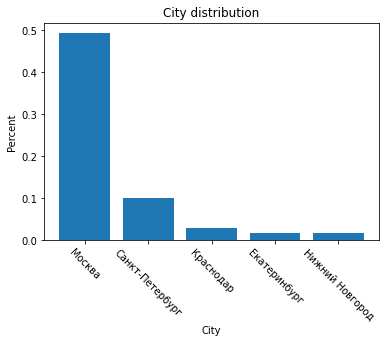

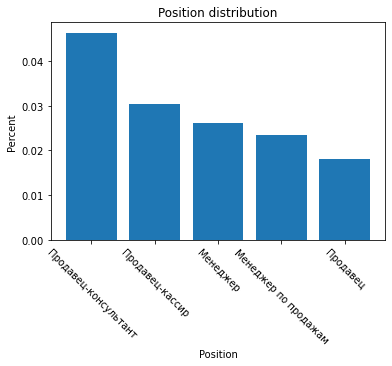

In [10]:
# city
plt.bar([i[0] for i in train[["city"]].value_counts(normalize=True).iloc[:5].index.values],
       train[["city"]].value_counts(normalize=True).iloc[:5].values)
plt.ylabel("Percent")
plt.xlabel("City")
plt.xticks(rotation=-45)
plt.title("City distribution")
plt.show()

# position
plt.bar([i[0] for i in train[["position"]].value_counts(normalize=True).iloc[:5].index.values],
       train[["position"]].value_counts(normalize=True).iloc[:5].values)
plt.ylabel("Percent")
plt.xlabel("Position")
plt.xticks(rotation=-45)
plt.title("Position distribution")
plt.show()

In [13]:
# NA
print("NaNs sum")
display(train.isna().sum())

print("-"*20)
print("NaNs Postive")
display(train[train["positive"].isna()==True]["target"].value_counts())

print("-"*20)
print("NaNs Negative")
display(train[train["negative"].isna()==True]["target"].value_counts())

print("-"*20)
print("NaNs Both")
display(train[(train["positive"].isna()==True)
             &((train["negative"].isna()==True))]["target"].value_counts())

# Test distribution
print("NaNs sum")
display(test.isna().sum())

NaNs sum


review_id                  0
city                    3350
position                4652
positive                   0
negative                  98
salary_rating              0
team_rating                0
managment_rating           0
career_rating              0
workplace_rating           0
rest_recovery_rating       0
target                     0
preprocessed_target        0
metadata_sum               0
dtype: int64

--------------------
NaNs Postive


Series([], Name: target, dtype: int64)

--------------------
NaNs Negative


0    98
Name: target, dtype: int64

--------------------
NaNs Both


Series([], Name: target, dtype: int64)

NaNs sum


review_id                  0
city                    3093
position                2227
positive                   1
negative                   3
salary_rating              0
team_rating                0
managment_rating           0
career_rating              0
workplace_rating           0
rest_recovery_rating       0
dtype: int64

In [15]:
# drop nans
train.dropna(subset=["positive", "negative"], inplace=True, how="all")
train.loc[train["negative"].isna(), "negative"] = ""

In [11]:
def preprocessing(sent:str, lowercase:bool=True,
                  remove_punctuation:bool=False, remove_stopwords:bool=False,
                  lemmatize:bool=False):
    # lowercase
    if lowercase:
        sent = sent.lower()
        
    # remove_punctuation
    if remove_punctuation:
        tokenizer = nltk.RegexpTokenizer(r'[а-я]+')
        sent = " ".join(tokenizer.tokenize(sent))
    
    # remove_stopwords
    if remove_stopwords:
        stopwords = nltk.corpus.stopwords.words("russian")
        sent = " ".join([w for w in sent.split() if w not in stopwords])
        
    # lemmatize
    if lemmatize:
        doc = Doc(sent)
        # Segmentation
        doc.segment(segmenter)

        # Morphology
        morph_tagger = NewsMorphTagger(emb)
        doc.tag_morph(morph_tagger)

        # Lemmatization
        for token in doc.tokens:
            token.lemmatize(morph_vocab)
        sent = " ".join([w.lemma for w in doc.tokens])
        
    return sent

In [12]:
# grab sentences
positive_sentences_raw = train["positive"].tolist()
negative_sentences_raw = train["negative"].tolist()

# init empty lists
positive_sentences = []
negative_sentences = []

# natasha utils
segmenter = Segmenter()
emb = NewsEmbedding()
morph_vocab = MorphVocab()

# preprocess
for sent in tqdm(positive_sentences_raw):
    sent = preprocessing(sent, lowercase=True, remove_punctuation=True, remove_stopwords=True,
                         lemmatize=True)
    positive_sentences.append(sent)
    del sent
    
for sent in tqdm(negative_sentences_raw):
    sent = preprocessing(sent, lowercase=True, remove_punctuation=True, remove_stopwords=True,
                         lemmatize=True)
    negative_sentences.append(sent)
    del sent

  0%|          | 0/50739 [00:00<?, ?it/s]

  0%|          | 0/50739 [00:00<?, ?it/s]

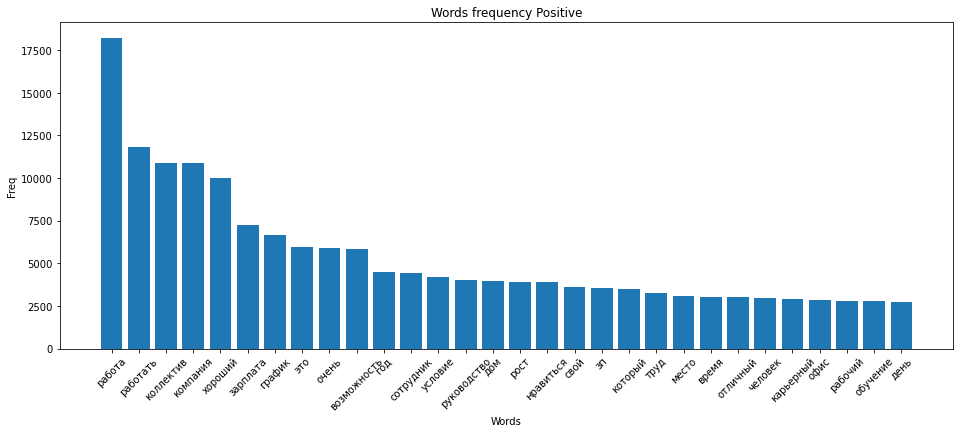

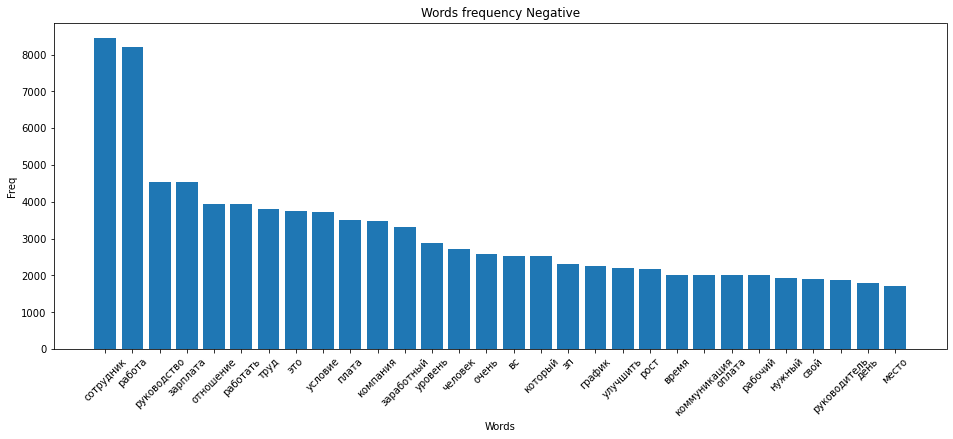

In [13]:
# Words Frequency Positive
wordfreq = nltk.FreqDist([w for sent in positive_sentences for w in sent.split()])
wordfreq = {k: v for k, v in sorted(dict(wordfreq).items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(16, 6))
plt.bar(list(wordfreq.keys())[:30], list(wordfreq.values())[:30])
plt.title("Words frequency Positive")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Freq")
plt.show()

# Words Frequency Negative
wordfreq = nltk.FreqDist([w for sent in negative_sentences for w in sent.split()])
wordfreq = {k: v for k, v in sorted(dict(wordfreq).items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(16, 6))
plt.bar(list(wordfreq.keys())[:30], list(wordfreq.values())[:30])
plt.title("Words frequency Negative")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Freq")
plt.show()

1) We don't need rows with missed both "positive" and "negative"\
2) More then 80% of targets are 0 or 8 values, it's would be great to train binary classification model\
3) We have multilabel but i'm not sure that we can submit multilabel\
4) We need somehow concat "positive", "negative" and "metadata" columns